# 8. 프로젝트_네이버 영화리뷰 감성분석
- 데이터 : https://github.com/e9t/nsmc

In [1]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


### 라이브러리 확인

In [2]:
import pandas
import konlpy
import gensim
import pandas as pd
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)
print(tf.__version__)

1.3.3
0.5.2
4.1.2
2.6.0


## 1) 데이터 준비와 확인

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터 로더 구성

- 데이터 로더를 직접 만들어야 함

__필수 구성요소__
1. 데이터의 중복 제거
1. NaN 결측치 제거
1. 한국어 토크나이저로 토큰화
1. 불용어(Stopwords) 제거
1. 사전word_to_index 구성
1. 텍스트 스트링을 사전 인덱스 스트링으로 변환
1. X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab  # 한국어 nlp 툴에서 토커나이저 불러오기
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 1. 중복데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)  
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 2. NaN값 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # 3. 한국어 토커나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        # 4. 불용어 제거
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 5. 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # 7. X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter.most_common(10000-4)

[(4.0, 159415),
 (3.0, 101159),
 (5.0, 57338),
 (6.0, 54971),
 (7.0, 47196),
 (8.0, 44376),
 (9.0, 29832),
 (10.0, 25603),
 (11.0, 22655),
 (12.0, 22161),
 (13.0, 22047),
 (14.0, 19269),
 (15.0, 19138),
 (16.0, 16685),
 (17.0, 15801),
 (18.0, 15323),
 (19.0, 13668),
 (20.0, 12601),
 (21.0, 12175),
 (22.0, 11669),
 (23.0, 11515),
 (24.0, 10974),
 (25.0, 10235),
 (26.0, 10106),
 (27.0, 10076),
 (28.0, 9751),
 (29.0, 9645),
 (30.0, 9340),
 (31.0, 9269),
 (32.0, 9098),
 (33.0, 9004),
 (34.0, 8758),
 (35.0, 8742),
 (36.0, 8574),
 (37.0, 8566),
 (38.0, 8361),
 (39.0, 8300),
 (40.0, 8156),
 (41.0, 8071),
 (42.0, 8055),
 (43.0, 7813),
 (44.0, 7726),
 (45.0, 7681),
 (46.0, 7614),
 (47.0, 7509),
 (48.0, 7469),
 (49.0, 7273),
 (50.0, 7197),
 (51.0, 6891),
 (52.0, 6833),
 (53.0, 6773),
 (54.0, 6573),
 (55.0, 6319),
 (56.0, 6317),
 (57.0, 6299),
 (58.0, 6248),
 (59.0, 5994),
 (60.0, 5902),
 (61.0, 5760),
 (62.0, 5534),
 (63.0, 5520),
 (64.0, 5477),
 (65.0, 5442),
 (66.0, 5419),
 (67.0, 5416),
 (68.

In [6]:
# 인덱스 : 워드 형태로 딕셔너리 만들기
# 나중에 인덱스를 단어로 반환해줌
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
----------------------------
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포
### 적절한 최대 문장 길이 지정

In [8]:
# 샘플 길이
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [9]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [10]:
# 인덱스가 3부터 시작이므로 1칸 뒤로 밀어준다.
# word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
# word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index["영화"])  # 6을 반환한다.
print(index_to_word[6])     # "영화"를 반환한다.

<BOS>
5
다


In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text] # 각 문장의 길이를 리스트에 넣는다.
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 

print('문장길이 평균 : ', round(np.mean(num_tokens),2))
print('문장길이 최대 : ', round(np.max(num_tokens),2))
print('문장길이 표준편차 : ', round(np.std(num_tokens),2))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100,2)))

문장길이 평균 :  15.97
문장길이 최대 :  116
문장길이 표준편차 :  12.84
pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
# padding을 pre와 post를 고르는 것도 성능에 많은 영향을 미친다. 
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성
-------------------------------
모델은 3가지 이상 다양하게 구성하여 실험해 보세요
1. convolution 1d
1. LSTM
1. maxpooling
1. GRU


## 5) 모델 훈련 개시
__________________
1. "adam" compiler 사용
1. epoch = 20
1. loss='binary_crossentropy'
1. metrics='accuracy'

## 6) Loss, Accuracy 그래프 시각화
__________________

### Validation set 나누기

In [13]:
round(X_train.shape[0]*0.8)

116946

In [14]:
# validation set 10000건 분리
x_val = X_train[:round(X_train.shape[0]*0.2)]   
y_val = y_train[:round(X_train.shape[0]*0.2)]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[round(X_train.shape[0]*0.2):]  
partial_y_train = y_train[round(X_train.shape[0]*0.2):]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116946, 41)
(116946,)


### Convolution-1D

__1. 모델 구성__

In [15]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          28688     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

__2. 모델 학습__

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 9ms/step - loss: 0.4848 - accuracy: 0.7566 - val_loss: 0.3527 - val_accuracy: 0.8454
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3177 - accuracy: 0.8661 - val_loss: 0.3349 - val_accuracy: 0.8539
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2724 - accuracy: 0.8893 - val_loss: 0.3440 - val_accuracy: 0.8527
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2227 - accuracy: 0.9130 - val_loss: 0.3601 - val_accuracy: 0.8541
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1644 - accuracy: 0.9402 - val_loss: 0.4073 - val_accuracy: 0.8485
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1148 - accuracy: 0.9612 - val_loss: 0.4722 - val_accuracy: 0.8427
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.0827 - accuracy: 0.9735 - val_loss: 0.5264 - val_accuracy: 0.8427
Epoch 

__3. 학습결과 시각화__

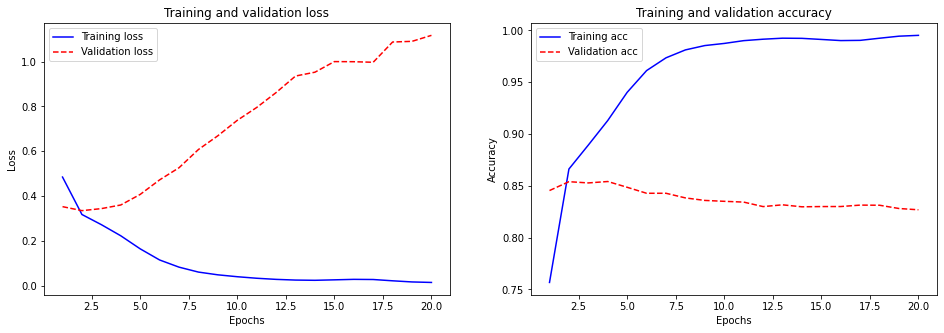

In [17]:
history_dict = history.history

# train과 validation 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

### LSMT

__1. 모델 구성__

In [18]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))   
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36992     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,598,081
Trainable params: 2,598,081
Non-trainable params: 0
_________________________________________________________________


__2. 모델 학습__

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 9ms/step - loss: 0.4659 - accuracy: 0.7586 - val_loss: 0.3525 - val_accuracy: 0.8468
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3275 - accuracy: 0.8599 - val_loss: 0.3337 - val_accuracy: 0.8533
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2902 - accuracy: 0.8764 - val_loss: 0.3338 - val_accuracy: 0.8596
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2562 - accuracy: 0.8923 - val_loss: 0.3336 - val_accuracy: 0.8597
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2259 - accuracy: 0.9060 - val_loss: 0.3640 - val_accuracy: 0.8560
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2011 - accuracy: 0.9171 - val_loss: 0.3805 - val_accuracy: 0.8530
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1813 - accuracy: 0.9266 - val_loss: 0.4212 - val_accuracy: 0.8495
Epoch 

__3. 학습결과 시각화__

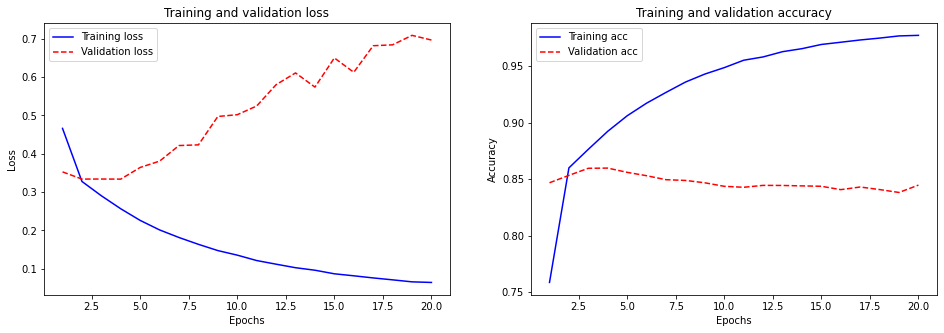

In [20]:
history_dict = history.history

# train과 validation 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

### Maxpooling

__1. 모델 구성__

In [21]:
# vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# # model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# # model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(64))
# # model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

__2. 모델 학습__

In [22]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# history = model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=epochs,
#                     batch_size=512,
#                     validation_data=(x_val, y_val),
#                     verbose=1)

__3. 학습결과 시각화__

In [23]:
# history_dict = history.history

# # train과 validation 시각화
# import matplotlib.pyplot as plt

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.figure(figsize = (16,5))

# plt.subplot(1,2,1)
# # "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'b', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'r--', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r--', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()


# plt.show()

### GRU

__1. 모델 구성__

In [24]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(32))   
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 32)                4800      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


__2. 모델 학습__

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=11  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/11
229/229 [==============================] - 3s 7ms/step - loss: 0.6005 - accuracy: 0.6213 - val_loss: 0.3751 - val_accuracy: 0.8348
Epoch 2/11
229/229 [==============================] - 1s 5ms/step - loss: 0.3531 - accuracy: 0.8474 - val_loss: 0.3479 - val_accuracy: 0.8503
Epoch 3/11
229/229 [==============================] - 1s 5ms/step - loss: 0.3251 - accuracy: 0.8622 - val_loss: 0.3456 - val_accuracy: 0.8500
Epoch 4/11
229/229 [==============================] - 1s 5ms/step - loss: 0.3111 - accuracy: 0.8703 - val_loss: 0.3459 - val_accuracy: 0.8504
Epoch 5/11
229/229 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.8759 - val_loss: 0.3525 - val_accuracy: 0.8494
Epoch 6/11
229/229 [==============================] - 1s 5ms/step - loss: 0.2894 - accuracy: 0.8813 - val_loss: 0.3471 - val_accuracy: 0.8532
Epoch 7/11
229/229 [==============================] - 1s 5ms/step - loss: 0.2796 - accuracy: 0.8852 - val_loss: 0.3458 - val_accuracy: 0.8545
Epoch 

__3. 학습결과 시각화__

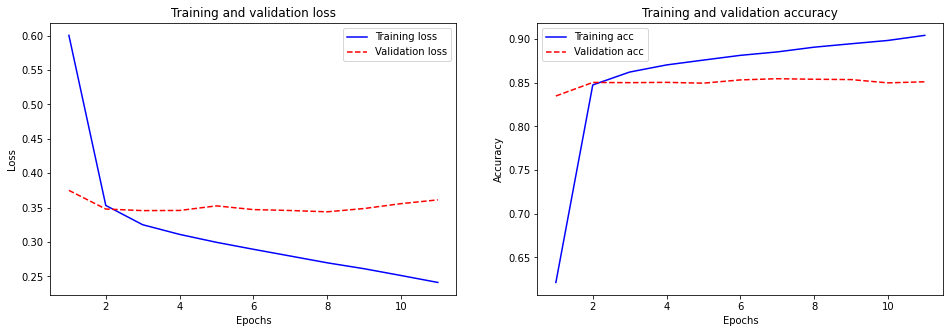

In [26]:
history_dict = history.history

# train과 validation 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

__결론__

> GRU의 성능이 가장 좋다

## 7) 학습된 Embedding 레이어 분석
__________________
 1. GRU를 활용

### layer 구성 확인

In [27]:
# 벡터 파일을 저장할 폴더를 만들고 
! mkdir -p ~/aiffel/03.Exploaration/[Exp_08]project_analitics_movie_review/data
# gensim의 버전 확인
! pip list | grep gensim

gensim                        4.1.2


In [28]:
embedding_layer = model.layers[0] # 
weights = embedding_layer.get_weights()[0]  #
print("model.layers의 구성")
for a in model.layers:
    print(a) 

print(weights.shape)    # shape: (vocab_size, embedding_dim)  # 10000개의 단어를 16차원에 넣었다. 

model.layers의 구성
(10000, 16)


In [29]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/03.Exploaration/[Exp_08]project_analitics_movie_review/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.05913771,  0.09769142,  0.0583213 ,  0.06955579, -0.04278782,
       -0.0416988 ,  0.13496232,  0.06892516,  0.04803143, -0.0927804 ,
       -0.04132768, -0.10152507, -0.12329659,  0.05110317,  0.10938267,
       -0.07571289], dtype=float32)

In [31]:
# 유사도를 통한 유사 단어 파악
word_vectors.similar_by_word("사랑")

[('최고', 0.9489472508430481),
 ('명작', 0.9098318219184875),
 ('괸', 0.9067826867103577),
 ('♥', 0.8999698162078857),
 ('짱', 0.8975966572761536),
 ('괜찮', 0.8965035080909729),
 ('놀라운', 0.8922609090805054),
 ('함부로', 0.8919986486434937),
 ('구매', 0.8907154202461243),
 ('벅찬', 0.8905048966407776)]

In [35]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3726 - accuracy: 0.8441
[0.37258589267730713, 0.8441320657730103]


> GRU 모델로 직접만든 워드벡터는 loss: 0.3726 - accuracy: 0.8441

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
__________________
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 

### 한국어 Word2Vec 확인

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv["사랑"]
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [37]:
word2vec.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

### 모델 학습및 평가

In [39]:
# 이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)  # 랜덤으로 틀을 만들어 놓고

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GRU(32))   
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,013,953
Trainable params: 1,013,953
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
229/229 [==============================] - 3s 8ms/step - loss: 0.6708 - accuracy: 0.5535 - val_loss: 0.5415 - val_accuracy: 0.7267
Epoch 2/8
229/229 [==============================] - 1s 6ms/step - loss: 0.4355 - accuracy: 0.7996 - val_loss: 0.3902 - val_accuracy: 0.8274
Epoch 3/8
229/229 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8453 - val_loss: 0.3549 - val_accuracy: 0.8461
Epoch 4/8
229/229 [==============================] - 1s 6ms/step - loss: 0.3203 - accuracy: 0.8632 - val_loss: 0.3460 - val_accuracy: 0.8497
Epoch 5/8
229/229 [==============================] - 1s 6ms/step - loss: 0.2978 - accuracy: 0.8755 - val_loss: 0.3418 - val_accuracy: 0.8540
Epoch 6/8
229/229 [==============================] - 1s 6ms/step - loss: 0.2820 - accuracy: 0.8833 - val_loss: 0.3380 - val_accuracy: 0.8558
Epoch 7/8
229/229 [==============================] - 1s 6ms/step - loss: 0.2665 - accuracy: 0.8909 - val_loss: 0.3453 - val_accuracy: 0.8542
Epoch 8/8
229

In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3549 - accuracy: 0.8525
[0.3549455404281616, 0.8525133728981018]


> GRU 모델에 한국어 Word2Vec를 사용해서 학습했을때 정확도와 loss 모두 좋아졌다.  
loss: 0.3549 - accuracy: 0.8525

__참고링크__
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models  
- https://radimrehurek.com/gensim/models/keyedvectors.html

## 루브릭
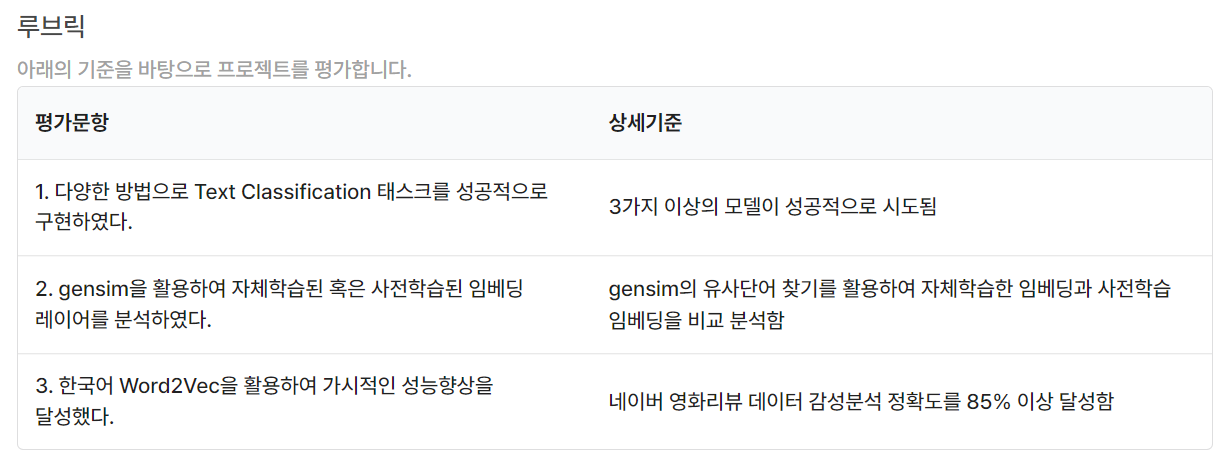

### 회고
1. 감성분석은 마케팅적으로 활용하기 좋은 프로젝트라서 이전부터 배워보고 싶었다. 텍스트를 통해서 별점을 예측할 수 있다는 점은 아주 매력적이었다. 
1. 사실 아직 완벽하게 이해가 되지는 않았다. 때문에 다음에 천천히 다른 프로젝트에 활용해 보고 싶다. 
1. genism을 활용해서 자체학습시킨 임베딩레잍